In [1]:
!pip install umap-learn
!pip install torchmetrics
!pip install torch-summary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 16.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


 Import libraries

In [3]:
# Standard python libraries
import collections
# Scientific python
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
# Great progress bar
import tqdm.auto as tqdm
# ML: PCA
import sklearn.decomposition
# Our DL stack
import torch
import torch.nn as nn
import torchvision
import torch.utils.data as torch_data

# DL utilities
import torchsummary
import torchmetrics

print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

1.13.1
Using device: cpu


**Extra:** Set random seed for reproducibility

In [4]:
torch.manual_seed(42)
np.random.seed(42)

# Get data

https://www.kaggle.com/datasets/zalando-research/fashionmnist


* Transforms are used to convert the images into 2D tensors in a $[0,1]$ numerical range.
* Dataset is split in train and test set.

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainval_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:03<00:00, 7462374.60it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 285050.54it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4735208.21it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4740346.21it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



**Extra:** split train into train/val splits

In [6]:
# Split dataset into train and validation sets
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = torch_data.random_split(trainval_dataset, [train_size, val_size])

In [7]:
batch_size = 256
train_loader = torch_data.DataLoader(train_dataset, batch_size=batch_size,
                                     shuffle=True)
val_loader = torch_data.DataLoader(val_dataset, batch_size=batch_size,
                                   shuffle=False)
test_loader = torch_data.DataLoader(test_dataset, batch_size=batch_size,
                                    shuffle=False)

Basic colors and numbers

In [8]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = sns.color_palette('Set3', len(class_names))
print("Number of training samples:", len(train_dataset))
print("Number of val      samples:", len(val_dataset))
print("Number of test     samples:", len(test_dataset))
print(class_names)

Number of training samples: 48000
Number of val      samples: 12000
Number of test     samples: 10000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


# Setting up a model class

Let's define a more general MLP

In [9]:
class MLP(nn.Module):
    """Multilayer Perceptron (MLP) model."""

    def __init__(self, input_size:int, hidden_size:int, num_layers:int, num_classes:int):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.LayerNorm(hidden_size)) # Layer Normalization
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.LayerNorm(hidden_size))  # Layer Normalization
        self.predict = nn.Linear(hidden_size, num_classes)

    def get_embedding(self, x):
        x = self.flatten(x)
        for layer in self.layers:
            x = layer(x)
        return x

    def forward(self, x):
        x = self.get_embedding(x)
        x = self.predict(x)
        return x

We create the model based on some hyper-parameters

In [10]:
input_size = 28 * 28
hidden_size = 50
num_layers = 3
num_classes = len(class_names)
model = MLP(input_size, hidden_size, num_layers, num_classes)
model = model.to(device)
print("Model Architecture:")
torchsummary.summary(model, (1, 28, 28))

Model Architecture:
Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 50]                  39,250
|    └─ReLU: 2-2                         [-1, 50]                  --
|    └─LayerNorm: 2-3                    [-1, 50]                  100
|    └─Linear: 2-4                       [-1, 50]                  2,550
|    └─ReLU: 2-5                         [-1, 50]                  --
|    └─LayerNorm: 2-6                    [-1, 50]                  100
|    └─Linear: 2-7                       [-1, 50]                  2,550
|    └─ReLU: 2-8                         [-1, 50]                  --
|    └─LayerNorm: 2-9                    [-1, 50]                  100
├─Linear: 1-2                            [-1, 10]                  510
Total params: 45,160
Trainable params: 45,160
Non-t

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 50]                  39,250
|    └─ReLU: 2-2                         [-1, 50]                  --
|    └─LayerNorm: 2-3                    [-1, 50]                  100
|    └─Linear: 2-4                       [-1, 50]                  2,550
|    └─ReLU: 2-5                         [-1, 50]                  --
|    └─LayerNorm: 2-6                    [-1, 50]                  100
|    └─Linear: 2-7                       [-1, 50]                  2,550
|    └─ReLU: 2-8                         [-1, 50]                  --
|    └─LayerNorm: 2-9                    [-1, 50]                  100
├─Linear: 1-2                            [-1, 10]                  510
Total params: 45,160
Trainable params: 45,160
Non-trainable params: 0
T

# Optimization


In [11]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [12]:
epochs = 50
patience = 5
clip_value = 1.0 # Gradient clipping value
early_stopping = EarlyStopping(patience=patience, verbose=True)
lr = 0.01

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.1,
                                                       patience=2) # Reduce LR on plateau

**Extra:** Define some metrics


In [14]:
train_metrics = torchmetrics.MetricCollection({
    'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=num_classes),
    'auroc': torchmetrics.AUROC(task="multiclass", num_classes=num_classes)
}).to(device)
val_metrics = torchmetrics.MetricCollection({
    'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=num_classes),
    'auroc': torchmetrics.AUROC(task="multiclass", num_classes=num_classes)
}).to(device)
test_metrics = torchmetrics.MetricCollection({
    'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device),
    'auroc': torchmetrics.AUROC(task="multiclass", num_classes=num_classes, average='macro').to(device) # Added average for multiclass
}).to(device)

In [15]:
# Function to evaluate the model
def evaluate(model, dataloader, metrics, criterion, device):
    model.eval()
    metrics.reset()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.softmax(outputs, dim=1)
            metrics.update(preds, labels)
    avg_loss = total_loss / len(dataloader)
    metrics_results = metrics.compute()
    metrics_cpu = {k: v.cpu().item() for k, v in metrics_results.items()}
    return {'loss': avg_loss, **metrics_cpu}

In [ ]:
history = []

pbar = tqdm.tqdm(range(1, epochs+1))
for epoch in pbar:
    model.train()
    train_loss = 0.0
    cur_lr = scheduler.get_last_lr()[0]
    train_metrics.reset()
    # Training loop
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        # Gradient clipping!
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        optimizer.step()
        train_loss += loss.item()

        # Collect batch metrics
        preds = torch.softmax(outputs, dim=1) # probabilities for AUROC
        train_metrics.update(preds, labels)

    # Epoch metrics
    train_results =  evaluate(model, train_loader, train_metrics, loss_fn, device)
    history.append({'epoch': epoch,
                    'split_part': 'train',
                    'lr': cur_lr} | train_results)
    # Validation loop
    val_results =  evaluate(model, val_loader, val_metrics, loss_fn, device)
    avg_val_loss = val_results['loss']
    history.append({'epoch': epoch,
                    'split_part': 'val',
                    'lr': cur_lr,}| val_results)

    pbar.set_postfix(history[-1])
    # Learning rate scheduling step - based on validation loss
    scheduler.step(avg_val_loss)
    # Early stopping check
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

  0%|          | 0/50 [00:25<?, ?it/s]


TypeError: unsupported operand type(s) for |: 'dict' and 'dict'

In [17]:
metrics_df = pd.DataFrame(history)
metrics_df

,epoch,split_part,lr,loss,accuracy,auroc
0,1,train,0.0100,0.481038,0.820917,0.984058
1,1,val,0.0100,0.505237,0.815667,0.982879
2,2,train,0.0100,0.379032,0.863896,0.988544
3,2,val,0.0100,0.411662,0.854583,0.986950
4,3,train,0.0100,0.372387,0.864208,0.988870
5,3,val,0.0100,0.407375,0.857333,0.987371
6,4,train,0.0100,0.348394,0.870854,0.990586
7,4,val,0.0100,0.388217,0.860917,0.988733
8,5,train,0.0100,0.336834,0.874083,0.991005
9,5,val,0.0100,0.372583,0.862167,0.989165


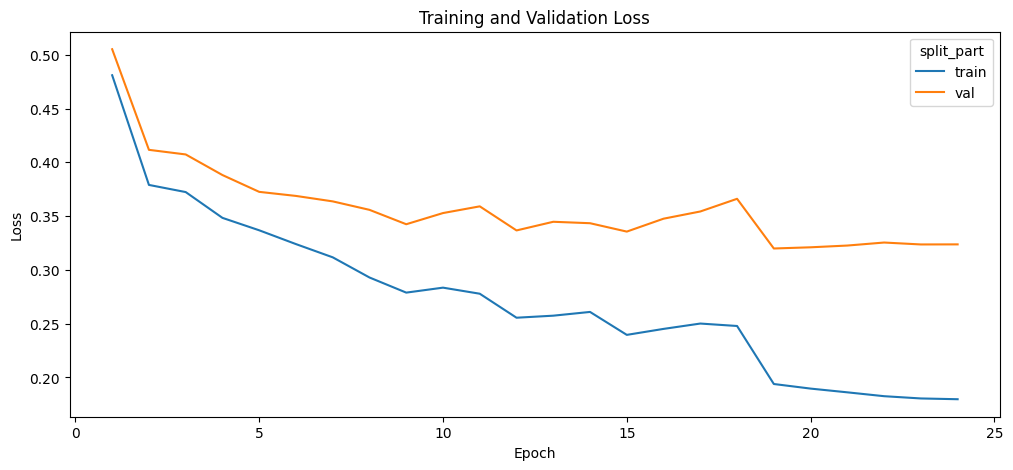

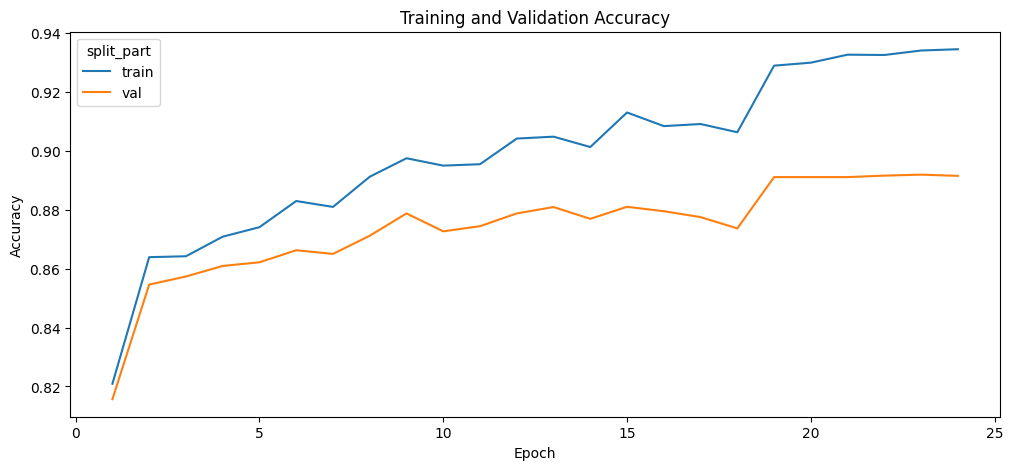

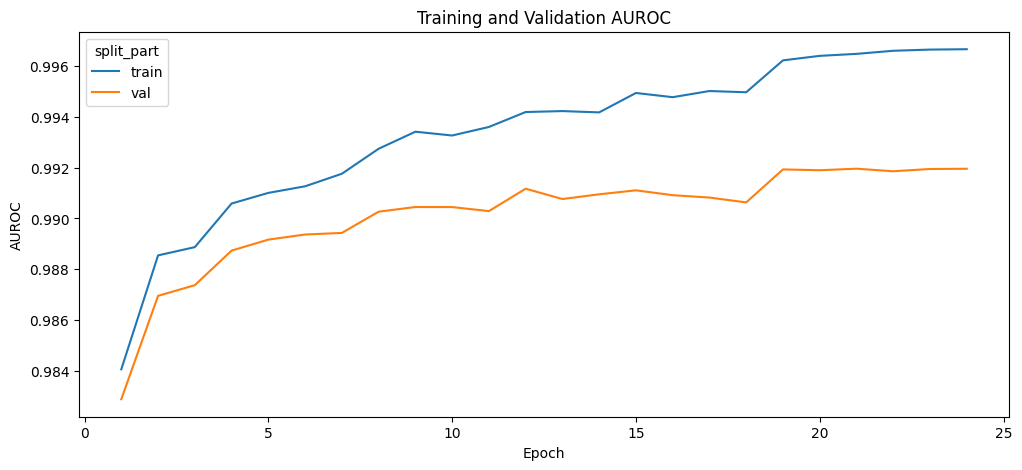

In [18]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=metrics_df, x='epoch', y='lr', hue='split_part')
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Learning rate')
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=metrics_df, x='epoch', y='loss', hue='split_part')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=metrics_df, x='epoch', y='accuracy', hue='split_part')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=metrics_df, x='epoch', y='auroc', hue='split_part')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.title('Training and Validation AUROC')
plt.show()

Let's tell the model we will stop training and just "evaluate"

In [ ]:
model.eval()

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
  )
  (predict): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
test_metrics_results = evaluate(model, test_loader, test_metrics, loss_fn, device)
test_metrics_results

{'loss': 0.3453739780932665,
 'accuracy': 0.8827999830245972,
 'auroc': 0.9902811050415039}

Let compute embeddings visualize the representation that we learned

In [ ]:
embedding_list = []
test_label_list = []
with torch.no_grad():
    for images, labels in test_loader:
        embeddings = model.get_embedding(images)
        embedding_list.extend(embeddings.numpy())
        test_label_list.extend(labels.numpy())

embeddings = np.array(embedding_list)
test_labels = np.array(test_label_list)
pca = sklearn.decomposition.PCA(n_components=2)
embeddings2d = pca.fit_transform(embeddings)
print(f'Reduce {embeddings.shape} to {embeddings2d.shape} via PCA')

Reduce (10000, 100) to (10000, 2) via PCA


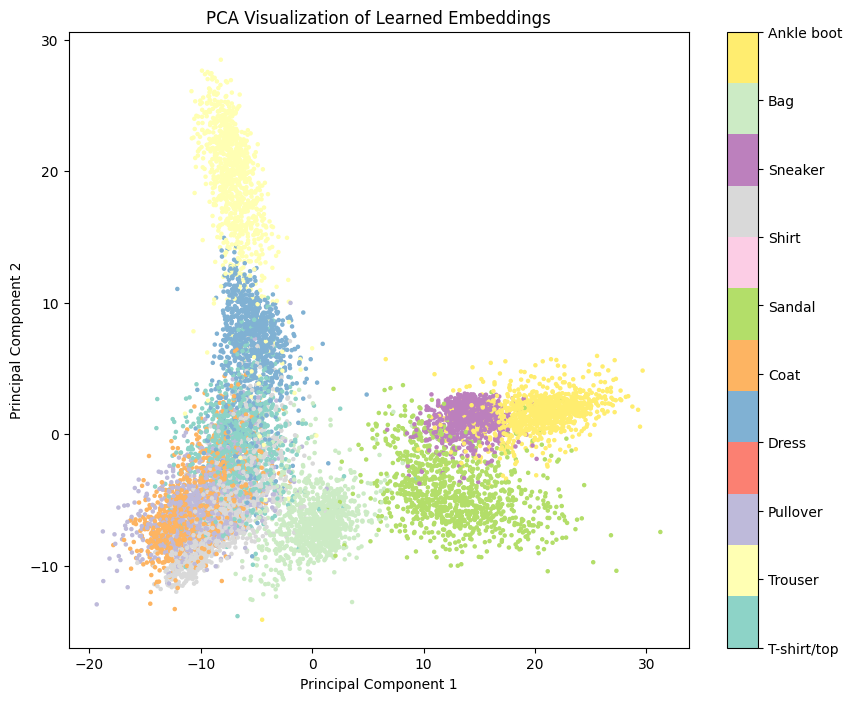

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings2d[:, 0], embeddings2d[:, 1], c=test_labels, cmap='Set3', s=5)
plt.title('PCA Visualization of Learned Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
colorbar = plt.colorbar(scatter, ticks=np.arange(len(class_names)))
colorbar.ax.set_yticklabels(class_names)
plt.show()